/var/folders/yb/bbjbf8z943q25wfq61jhp0gh0000gn/T/ipykernel_27473/1662424407.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


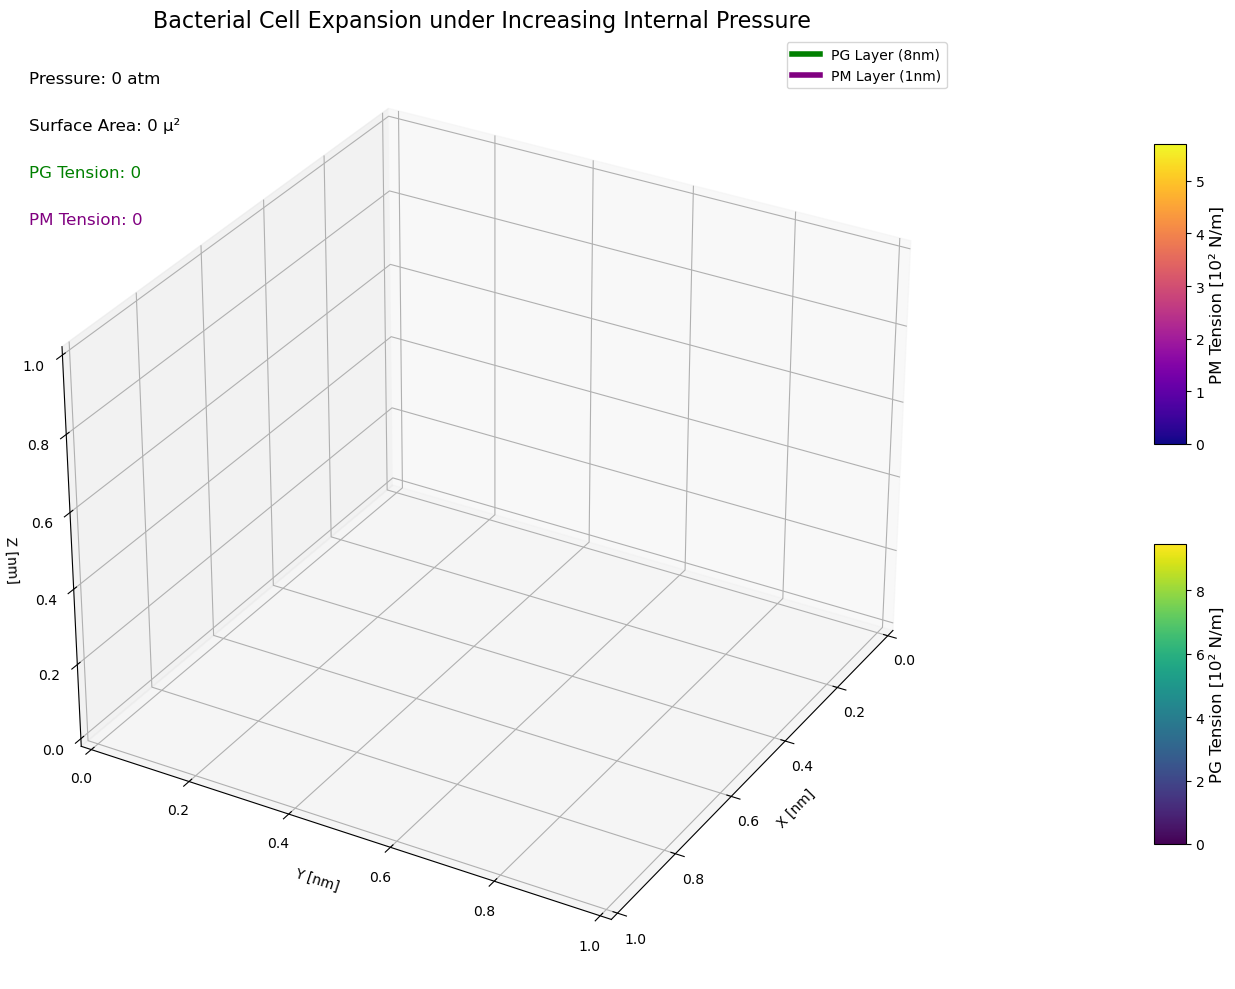

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame:', max=299), Output()), _…

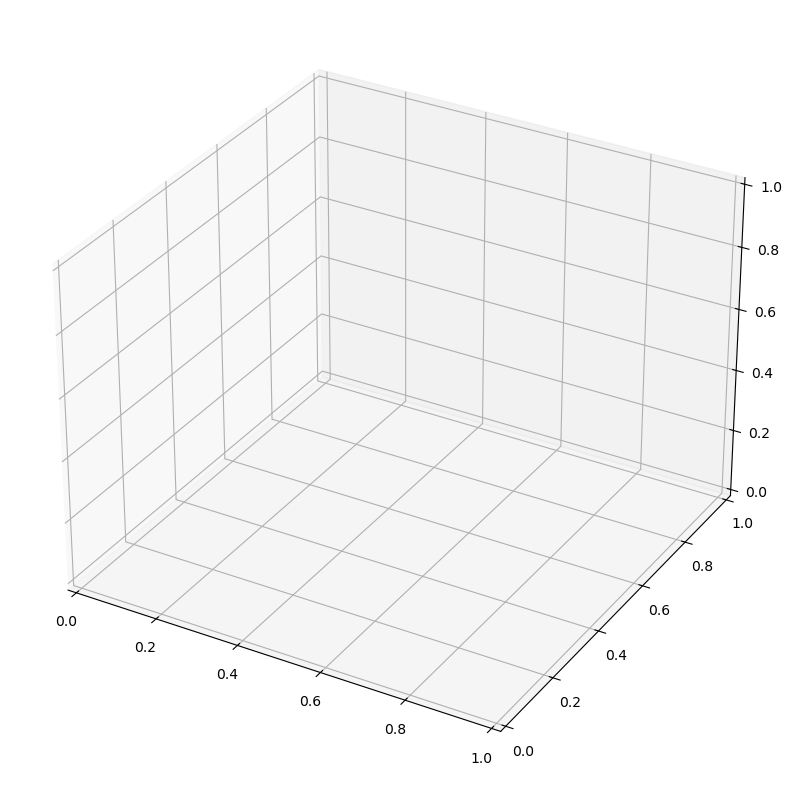

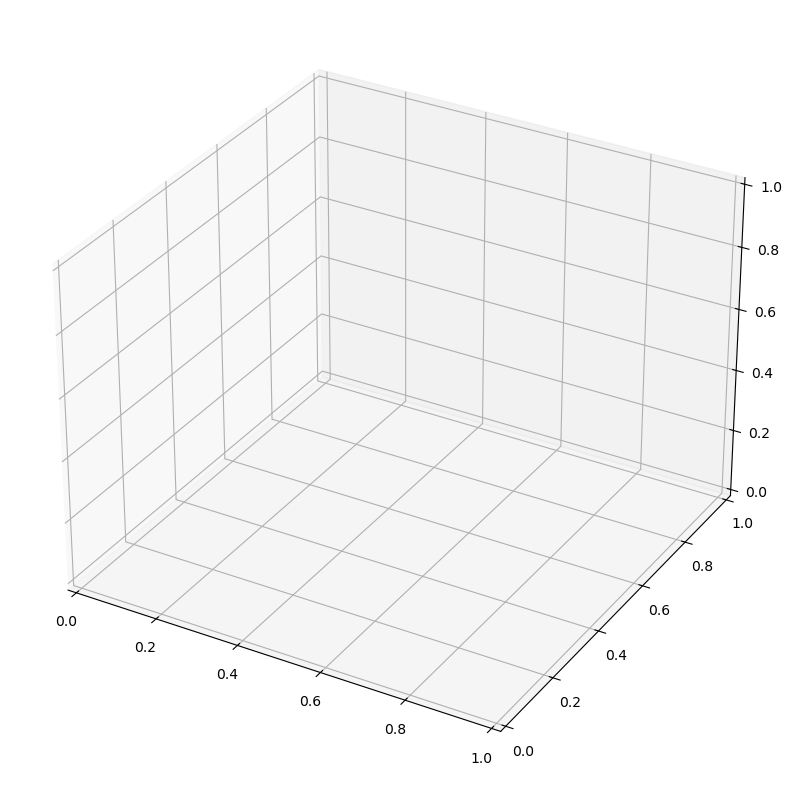

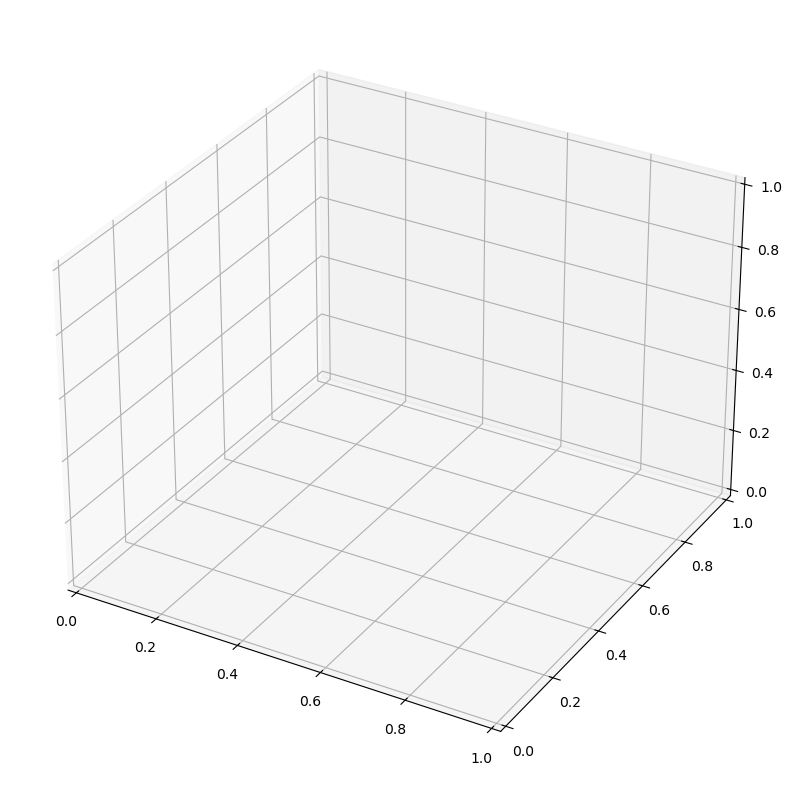

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import time

# Load the data
pressure_data = pd.read_csv('plot_data_first_1.csv')
area_data = pd.read_csv('plot_data_second_1.csv')

# Constants for the bacteria model
outer_thickness = 8  # nm (PG layer)
inner_thickness = 1  # nm (PM layer)

# Define functions to calculate the radius from surface area (assuming spherical shape)
def surface_area_to_radius(area):
    """Convert surface area to radius, assuming a sphere"""
    return np.sqrt(area / (4 * np.pi))

# Add radius column to area_data
area_data['Radius [nm]'] = surface_area_to_radius(area_data['Internal Surface Area [µ²]'])

# Function to create sphere mesh with a section cut out
def create_cutout_sphere(radius, resolution=30):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Create a cutout (remove 1/8 of the sphere)
    mask = ~((x > 0) & (y > 0) & (z > 0))
    x[~mask] = np.nan
    y[~mask] = np.nan
    z[~mask] = np.nan
    
    return x, y, z

# Function to find closest pressure for a given area
def get_tension_for_area(area_val, area_df=area_data):
    """Get PG and PM tension values for a given surface area"""
    idx = (area_df['Internal Surface Area [µ²]'] - area_val).abs().idxmin()
    return area_df.loc[idx, 'PG Tension [10^2 N/m]'], area_df.loc[idx, 'PM Tension [10^2 N/m]']

# Function to find corresponding pressure for a given area
def get_pressure_for_area(area_val, area_df=area_data, pressure_df=pressure_data):
    """Find the closest pressure value for a given surface area"""
    # First get the tension values for the area
    pg_tension, pm_tension = get_tension_for_area(area_val, area_df)
    
    # Then find the closest matching tension values in the pressure data
    tension_distance = (
        ((pressure_df['PG Tension [10^2 N/m]'] - pg_tension) / pg_tension.max())**2 + 
        ((pressure_df['PM Tension [10^2 N/m]'] - pm_tension) / pm_tension.max())**2
    )
    if not np.isnan(tension_distance).all():
        idx = tension_distance.nsmallest(1).index[0]
        return pressure_df.loc[idx, 'Internal Pressure [atm]']
    return 0

# Setup the figure and 3D axis
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Create custom color maps for different tension ranges
pg_cmap = cm.viridis
pm_cmap = cm.plasma

# Normalize color maps based on the data ranges
pg_norm = colors.Normalize(
    vmin=0, 
    vmax=area_data['PG Tension [10^2 N/m]'].max()
)
pm_norm = colors.Normalize(
    vmin=0, 
    vmax=area_data['PM Tension [10^2 N/m]'].max()
)

# Text annotations for displaying values
pressure_text = ax.text2D(0.02, 0.95, "Pressure: 0 atm", transform=ax.transAxes, fontsize=12)
area_text = ax.text2D(0.02, 0.90, "Surface Area: 0 µ²", transform=ax.transAxes, fontsize=12)
pg_tension_text = ax.text2D(0.02, 0.85, "PG Tension: 0", transform=ax.transAxes, fontsize=12, color='green')
pm_tension_text = ax.text2D(0.02, 0.80, "PM Tension: 0", transform=ax.transAxes, fontsize=12, color='purple')

# Initialize plots for both layers
outer_surface = None
inner_surface = None

# Setup colorbar axes
cbar_ax1 = fig.add_axes([0.92, 0.15, 0.02, 0.3])
cbar_ax2 = fig.add_axes([0.92, 0.55, 0.02, 0.3])

# Create colorbars
cbar1 = plt.colorbar(cm.ScalarMappable(norm=pg_norm, cmap=pg_cmap), cax=cbar_ax1)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=pm_norm, cmap=pm_cmap), cax=cbar_ax2)

# Add labels to colorbars
cbar1.set_label('PG Tension [10² N/m]', fontsize=12)
cbar2.set_label('PM Tension [10² N/m]', fontsize=12)

# Animation update function
def update(frame):
    global outer_surface, inner_surface
    
    # Get current area value from the data
    area_val = area_data.iloc[frame]['Internal Surface Area [µ²]']
    radius = area_data.iloc[frame]['Radius [nm]']
    
    # Get tension values for the current area
    pg_tension = area_data.iloc[frame]['PG Tension [10^2 N/m]']
    pm_tension = area_data.iloc[frame]['PM Tension [10^2 N/m]']
    
    # Get corresponding pressure
    pressure = get_pressure_for_area(area_val)
    
    # Clear previous surfaces
    if outer_surface:
        outer_surface.remove()
    if inner_surface:
        inner_surface.remove()
    
    # Calculate radii for both layers
    outer_radius = radius + inner_thickness + outer_thickness/2
    inner_radius = radius + inner_thickness/2
    
    # Create new meshes for both layers
    x_outer, y_outer, z_outer = create_cutout_sphere(outer_radius)
    x_inner, y_inner, z_inner = create_cutout_sphere(inner_radius)
    
    # Plot the surfaces with tension-based coloring
    outer_surface = ax.plot_surface(
        x_outer, y_outer, z_outer, 
        color='green', alpha=0.7,
        facecolors=pg_cmap(pg_norm(pg_tension)),
        rstride=1, cstride=1, linewidth=0, antialiased=True
    )
    
    inner_surface = ax.plot_surface(
        x_inner, y_inner, z_inner, 
        color='purple', alpha=0.7,
        facecolors=pm_cmap(pm_norm(pm_tension)),
        rstride=1, cstride=1, linewidth=0, antialiased=True
    )
    
    # Update text displays
    pressure_text.set_text(f"Pressure: {pressure:.2f} atm")
    area_text.set_text(f"Surface Area: {area_val:.2f} µ²")
    pg_tension_text.set_text(f"PG Tension: {pg_tension:.2f} [10² N/m]")
    pm_tension_text.set_text(f"PM Tension: {pm_tension:.2f} [10² N/m]")
    
    # Set axis limits dynamically based on maximum radius
    max_radius = outer_radius * 1.2
    ax.set_xlim([-max_radius, max_radius])
    ax.set_ylim([-max_radius, max_radius])
    ax.set_zlim([-max_radius, max_radius])
    
    return outer_surface, inner_surface, pressure_text, area_text, pg_tension_text, pm_tension_text

# Set labels and title
ax.set_xlabel('X [nm]')
ax.set_ylabel('Y [nm]')
ax.set_zlabel('Z [nm]')
ax.set_title('Bacterial Cell Expansion under Increasing Internal Pressure', fontsize=16)

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='PG Layer (8nm)'),
    Line2D([0], [0], color='purple', lw=4, label='PM Layer (1nm)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Set the initial view angle
ax.view_init(elev=30, azim=30)

# Create the animation (use a subset of frames for smoother animation)
step = 3  # Adjust this to control animation speed
frames = range(0, len(area_data), step)
ani = animation.FuncAnimation(
    fig, update, frames=frames, interval=100, blit=False
)

# Save the animation (uncomment to save)
# ani.save('bacteria_expansion.mp4', writer='ffmpeg', fps=15, dpi=200)

# Show the figure
plt.tight_layout()
plt.show()

# Function to create an interactive figure with controls
def create_interactive_visualization():
    from ipywidgets import interact, IntSlider
    
    def plot_state(frame_idx):
        # Get current area value from the data
        area_val = area_data.iloc[frame_idx]['Internal Surface Area [µ²]']
        radius = area_data.iloc[frame_idx]['Radius [nm]']
        
        # Get tension values for the current area
        pg_tension = area_data.iloc[frame_idx]['PG Tension [10^2 N/m]']
        pm_tension = area_data.iloc[frame_idx]['PM Tension [10^2 N/m]']
        pressure = get_pressure_for_area(area_val)
        
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Calculate radii for both layers
        outer_radius = radius + inner_thickness + outer_thickness/2
        inner_radius = radius + inner_thickness/2
        
        # Create meshes for both layers
        x_outer, y_outer, z_outer = create_cutout_sphere(outer_radius)
        x_inner, y_inner, z_inner = create_cutout_sphere(inner_radius)
        
        # Plot the surfaces with tension-based coloring
        ax.plot_surface(
            x_outer, y_outer, z_outer, 
            color='green', alpha=0.7,
            facecolors=pg_cmap(pg_norm(pg_tension)),
            rstride=1, cstride=1, linewidth=0, antialiased=True
        )
        
        ax.plot_surface(
            x_inner, y_inner, z_inner, 
            color='purple', alpha=0.7,
            facecolors=pm_cmap(pm_norm(pm_tension)),
            rstride=1, cstride=1, linewidth=0, antialiased=True
        )
        
        # Add text displays
        ax.text2D(0.02, 0.95, f"Pressure: {pressure:.2f} atm", transform=ax.transAxes)
        ax.text2D(0.02, 0.90, f"Surface Area: {area_val:.2f} µ²", transform=ax.transAxes)
        ax.text2D(0.02, 0.85, f"PG Tension: {pg_tension:.2f} [10² N/m]", transform=ax.transAxes, color='green')
        ax.text2D(0.02, 0.80, f"PM Tension: {pm_tension:.2f} [10² N/m]", transform=ax.transAxes, color='purple')
        
        # Set labels and title
        ax.set_xlabel('X [nm]')
        ax.set_ylabel('Y [nm]')
        ax.set_zlabel('Z [nm]')
        ax.set_title(f'Bacterial Cell at {pressure:.2f} atm Pressure', fontsize=16)
        
        # Add a legend
        legend_elements = [
            Line2D([0], [0], color='green', lw=4, label='PG Layer (8nm)'),
            Line2D([0], [0], color='purple', lw=4, label='PM Layer (1nm)')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        
        # Set the view angle
        ax.view_init(elev=30, azim=30)
        
        # Set axis limits
        max_radius = outer_radius * 1.2
        ax.set_xlim([-max_radius, max_radius])
        ax.set_ylim([-max_radius, max_radius])
        ax.set_zlim([-max_radius, max_radius])
        
        plt.tight_layout()
        plt.show()
    
    # Create an interactive slider
    interact(
        plot_state, 
        frame_idx=IntSlider(
            min=0, max=len(area_data)-1, step=1, value=0,
            description='Frame:', continuous_update=False
        )
    )

# To use the interactive visualization in Jupyter notebook, uncomment the line below
create_interactive_visualization()